In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob  # Para manejar múltiples archivos

# Configuración de seaborn para gráficos mas agradables
sns.set_theme(style="whitegrid")

In [49]:

files = glob.glob("stats-ej1-d/*.txt") # Recolectar archivos con métricas

data_list = []

for file in files:
    with open(file, 'r') as f:
        cache = None
        vias = None
        metrics = {}
        
        for line in f:
            line = line.strip()

            if line.startswith("cache"): # Si la línea es de cache o vias, extraer su valor
                cache = line.split()[1]
            elif line.startswith("vias"):
                vias = line.split()[1]
            elif line:
                parts = line.split()
                if len(parts) == 2:
                    metric, value = parts
                    metrics[metric] = float(value)
        
        metrics['cache'] = cache
        metrics['vias'] = vias

        data_list.append(pd.DataFrame([metrics])) # Añadir el diccionario de métricas a la lista como un DataFrame

data = pd.concat(data_list, ignore_index=True)

grouped_data = data.groupby(['cache', 'vias']).mean().reset_index()
#print(grouped_data)

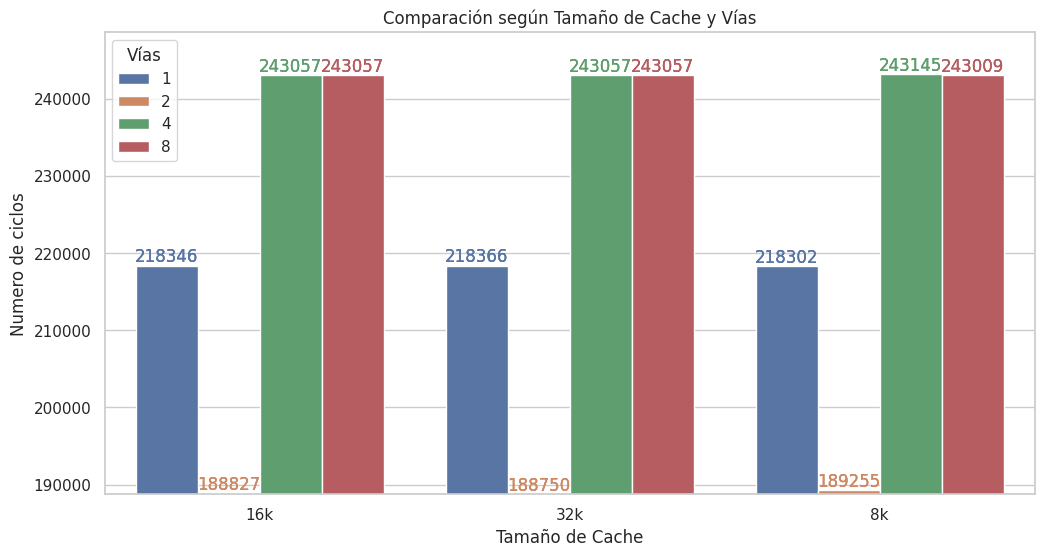

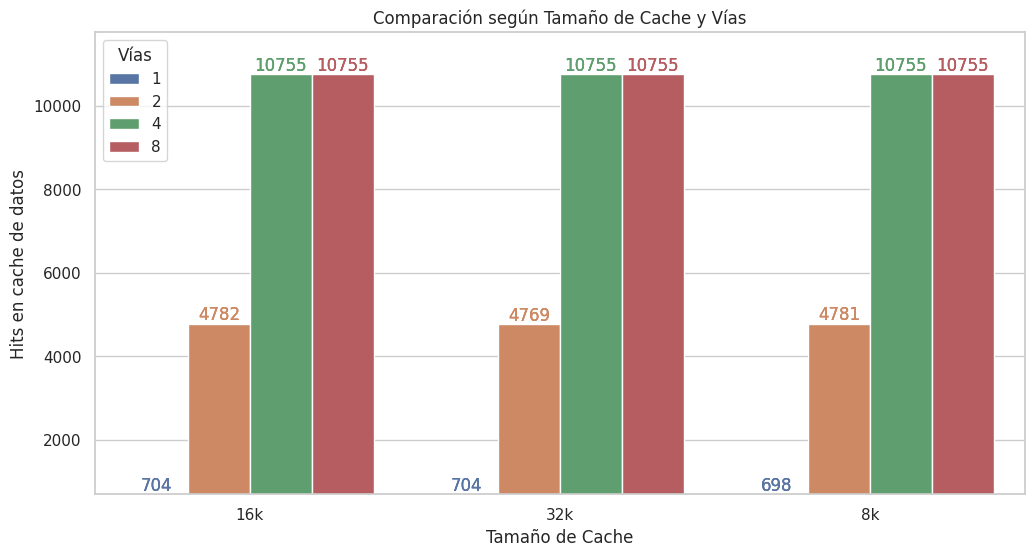

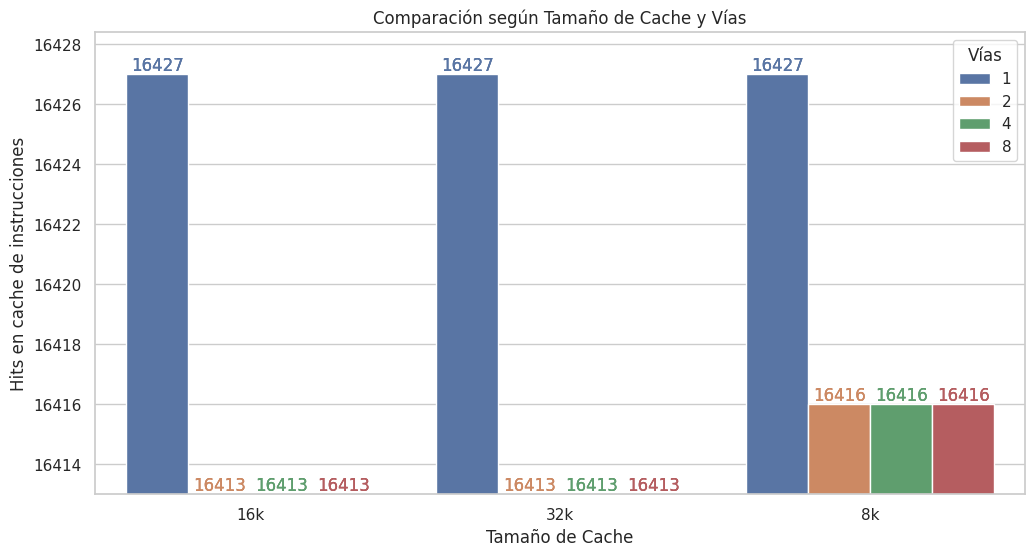

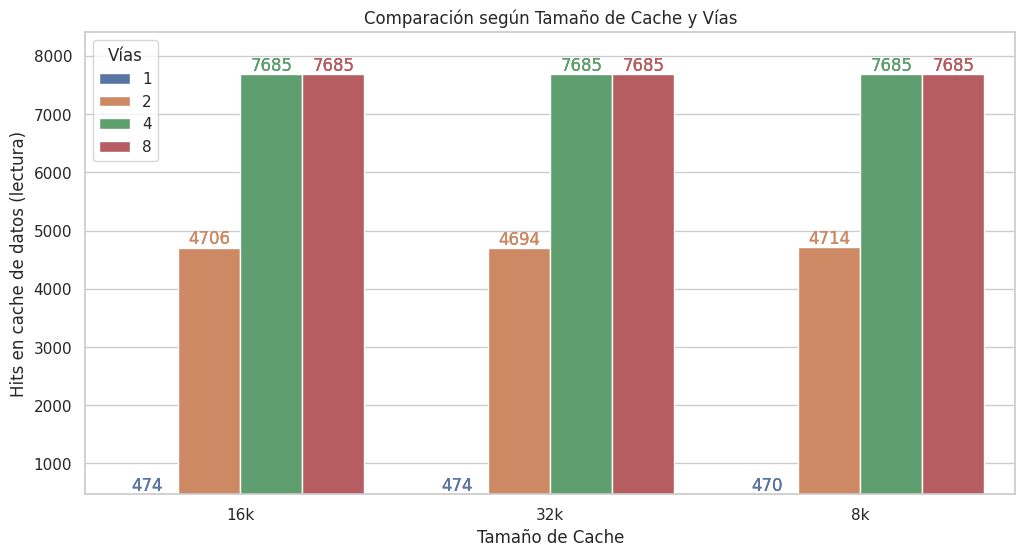

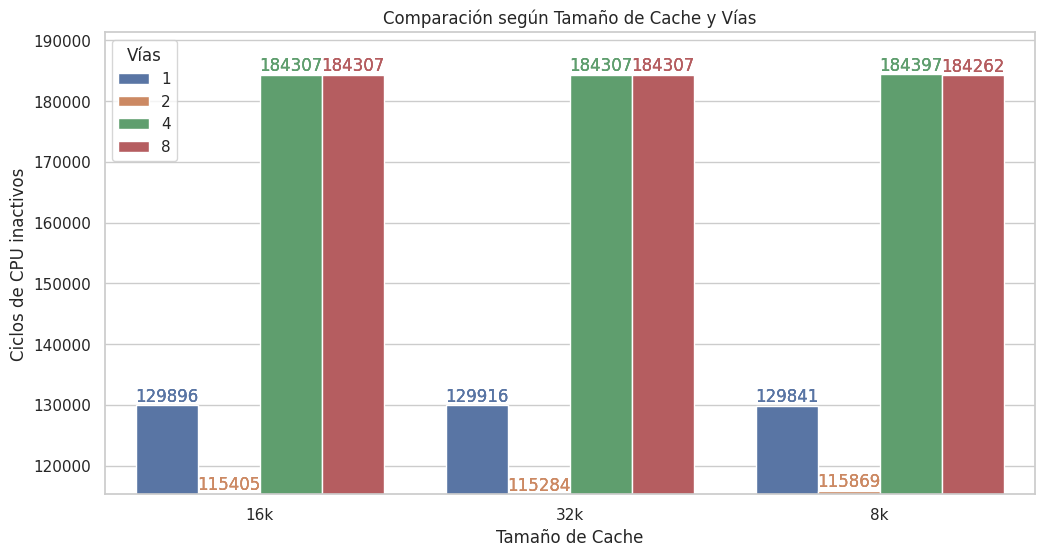

In [60]:
def generate_cache_barplot(y, alias, data):
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(data=data, x='cache', y=y, hue='vias')
    
    ax.set_xlabel('Tamaño de Cache')
    ax.set_ylabel(alias)
    ax.set_title('Comparación según Tamaño de Cache y Vías')
    ax.legend(title="Vías")

    lower_bound = data[y].min()
    upper_bound = data[y].max() + (data[y].max() - lower_bound) * 0.1
    ax.set_ybound(lower=lower_bound, upper=upper_bound)
    
    for container in ax.containers:
        for bar in container:
            color = bar.get_facecolor()
            ax.bar_label(container, fmt="%.0f", color=color)

    plt.show()


generate_cache_barplot('system.cpu_cluster.cpus.numCycles', 'Numero de ciclos', grouped_data)
generate_cache_barplot('system.cpu_cluster.cpus.dcache.overallHits::total', 'Hits en cache de datos', grouped_data)
generate_cache_barplot('system.cpu_cluster.cpus.icache.overallHits::total', 'Hits en cache de instrucciones', grouped_data)
generate_cache_barplot('system.cpu_cluster.cpus.dcache.ReadReq.hits::total', 'Hits en cache de datos (lectura)', grouped_data)
generate_cache_barplot('system.cpu_cluster.cpus.idleCycles', 'Ciclos de CPU inactivos', grouped_data)